In [3]:
import joblib
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import  Pipeline
from sklearn.ensemble import GradientBoostingRegressor

data_set_train_pd = joblib.load('../data/data_set_train_pd.pkl')
data_set_test_pd = joblib.load('../data/data_set_test_pd.pkl')

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(['ggplot'])

# Apply CountVevtorizer
+ Feature: MaterialDescription

In [8]:
def run_cv_test(model, X, y):
    pipe= Pipeline([
        ('CountVectorizer', CountVectorizer(
            tokenizer=word_tokenize, 
            	token_pattern=None, 
                max_features=300)),
        ('model', model())])

    scores = cross_val_score(
        pipe, 
        X, y, cv=5, scoring='neg_mean_absolute_error')
    print("%0.2f accuracy with a standard deviation of %0.2f" % (
                                        -1*scores.mean(), scores.std()))
    return -1*scores

In [9]:
run_cv_test(LinearRegression, 
    X = data_set_train_pd['MaterialDescription'], 
    y = data_set_train_pd['TransportationDays'])

5.60 accuracy with a standard deviation of 0.13


array([5.56141978, 5.58481354, 5.68396304, 5.77099697, 5.39153595])

In [10]:

run_cv_test(GradientBoostingRegressor, 
    X = data_set_train_pd['MaterialDescription'], 
    y = data_set_train_pd['TransportationDays'])

5.81 accuracy with a standard deviation of 0.06


array([5.7473457 , 5.76733293, 5.91115937, 5.85790459, 5.7765282 ])

# Learn Embedings
+ Use deep learning to learn embeddings

## Build Vocabulary
1) Build Vocabulary. Use collections. Counter on feature Material Description. Use word_tokenize from NLTK. 
2) Vocabulary is sorted by most frequent word to least.
3) Transform each material description into a vector whose entries correspont to the index of the token/word.
4) Truncate or pad with zeros so that the dimension of the vectorial representation is fixed.

In [11]:
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

vocab_size = 500

def build_vocabulary(series, vocab_size):
    tokens = []
    vocab_to_int = {}
    for data in series:
        temp = [each for each in word_tokenize(data) if len(each)>1]
        tokens = temp if len(tokens)==0 else tokens + temp
    counts = Counter(tokens)
    vocab = sorted(counts, key=counts.get, reverse= True)
    for ii, word in enumerate(vocab, 1):
        if ii == vocab_size:
            break
        vocab_to_int[word] = int(ii)
    return vocab_to_int

vocabulary = build_vocabulary(data_set_train_pd.MaterialDescription, vocab_size= vocab_size)
top_5 = [key for key, value in vocabulary.items() if value<5]
lower_5 = [key for key, value in vocabulary.items() if value>vocab_size-5]
mid_5   = [key for key, value in vocabulary.items() if 150<=value<=155]
print(f' Top 5 tokens {(top_5)}.  ')
print(f' mid 5 {mid_5}.')
print(f' lower 5 {lower_5}. ')


transform_x = []
for each in data_set_train_pd.MaterialDescription:
    temp = []
    for each in word_tokenize(each):
        if len(each)>1:
            if vocabulary.get(each) is not None:
                temp.append(vocabulary.get(each))
    if len(temp)>50:
        temp  = temp[0:50]
    else:
        while len(temp)<50:
            temp.append(0)
    transform_x.append(temp)

 Top 5 tokens ['25KG', '1A1', '31HA1', '5H4'].  
 mid 5 ['60KG', '0,5L', '200L', '10KG', '15KG', '90037'].
 lower 5 ['SPONGOLIT', '18', 'NORMAL', '225']. 


In [12]:
# Sample top 10 of fiest entry.
transform_x[0][:10]

[113, 13, 0, 0, 0, 0, 0, 0, 0, 0]

# Build the Network

In [13]:
class GetEmbedings(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(GetEmbedings, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)
        self.fc5 = nn.Linear(10, 5)
        self.fc6 = nn.Linear(5, 5)
        self.fc7 = nn.Linear(5, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.long()
        embeds = self.embedding(x)
        x = self.dropout(F.relu(self.fc(embeds)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
        x = self.dropout(F.relu(self.fc6(x)))
        out = self.fc7(x)
        return out

# network
model = GetEmbedings(
    vocab_size= vocab_size, 
    embedding_dim = 10)

## Build Tensor loaders
+ Use validation as 20% of training

In [14]:
batch_size = 150
valid_size = 0.2

train_data = TensorDataset(
    torch.from_numpy(np.array(transform_x)), 
    torch.from_numpy(np.array(data_set_train_pd['TransportationDays'], 
    dtype='f' )))

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)

## Training loop

In [16]:
# mean abosulte error (Easy interpretation)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_on_gpu = False
n_epochs = 20
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), '../data/model_param.pt')
        valid_loss_min = valid_loss

c:\Users\CiodarG\Anaconda3\envs\pytorch_cpu_env\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
c:\Users\CiodarG\Anaconda3\envs\pytorch_cpu_env\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([102])) that is different to the input size (torch.Size([102, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
c:\Users\CiodarG\Anaconda3\envs\pytorch_cpu_env\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 50, 1])). This will likely lead to incorrect resul

Epoch: 1 	Training Loss: 6.372227 	Validation Loss: 6.084307
Validation loss decreased (inf --> 6.084307).  Saving model ...
Epoch: 2 	Training Loss: 6.015918 	Validation Loss: 6.028682
Validation loss decreased (6.084307 --> 6.028682).  Saving model ...
Epoch: 3 	Training Loss: 5.950079 	Validation Loss: 6.021841
Validation loss decreased (6.028682 --> 6.021841).  Saving model ...
Epoch: 4 	Training Loss: 5.924319 	Validation Loss: 6.020318
Validation loss decreased (6.021841 --> 6.020318).  Saving model ...
Epoch: 5 	Training Loss: 5.909150 	Validation Loss: 6.025029
Epoch: 6 	Training Loss: 5.892422 	Validation Loss: 6.021370
Epoch: 7 	Training Loss: 5.875438 	Validation Loss: 6.021659
Epoch: 8 	Training Loss: 5.861941 	Validation Loss: 6.015593
Validation loss decreased (6.020318 --> 6.015593).  Saving model ...
Epoch: 9 	Training Loss: 5.849274 	Validation Loss: 6.015543
Validation loss decreased (6.015593 --> 6.015543).  Saving model ...
Epoch: 10 	Training Loss: 5.843982 	Valida

+ We see the loss MAE on training is quite similar to the one found with simple CountVectorizer and Linear Regression 5.8

In [15]:
# Load best model bases on validation loss
model.load_state_dict(torch.load('../data/model_param.pt'))

<All keys matched successfully>

## Extract only the embeding layer
+ Use the learnt embeding layer to get a general vector representing the MaterialDescription sentence

In [16]:
extrac_embeding = model.embedding

vectorial_representation = []
for each in transform_x:
    vectorial_representation.append(
        np.mean(extrac_embeding(torch.tensor(each)).detach().numpy(),
         axis=0))

## Explore Manifold

In [17]:
from sklearn.manifold import TSNE

x_projection = np.array(vectorial_representation)

projection = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    n_iter=500,
    n_iter_without_progress=150,
    random_state=0
    )

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(x_projection)

<AxesSubplot:xlabel='projections_1', ylabel='projections_2'>

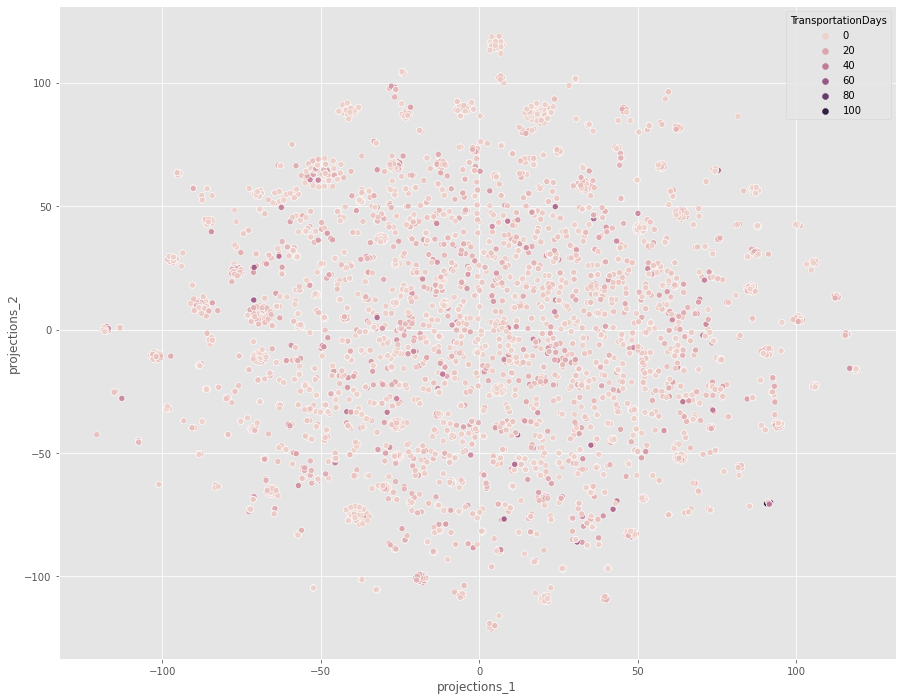

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 12)) 
ax0 = fig.add_subplot(1, 1, 1)
temp = pd.DataFrame(
    X_embedded,
    columns=['projections_1','projections_2']).join(data_set_train_pd['TransportationDays'])
sns.scatterplot(
    data= temp,
    x="projections_1", 
    y="projections_2",
     hue="TransportationDays", ax=ax0)

+ No patter was found. The embeding did not find a patter to Transporation

## Try to find cluster using DBscan

In [37]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [47]:
x_projection = np.array(vectorial_representation)
scaler = MinMaxScaler()
x_projection = scaler.fit_transform(x_projection)

clustering = DBSCAN(eps=0.15, min_samples=20, metric='euclidean')
x_clus = clustering.fit_predict(x_projection)

# DBscan with embedings
x_clus_df = pd.DataFrame(x_clus, columns=['cluster_with_embedings'])

In [41]:
# DBscan with CountVectorizer (simplest)
vectorizer = CountVectorizer(tokenizer= word_tokenize, 
                            token_pattern= None, 
                            max_features= 300)

x_bag = vectorizer.fit_transform(data_set_train_pd['MaterialDescription'])
x_bag = x_bag.todense()
#scaler_bag = MinMaxScaler()
#x_bag_scaled = scaler_bag.fit_transform(x_bag)

clustering_count = DBSCAN(eps=0.15, min_samples=20, metric='jaccard')
x_clus_count = clustering_count.fit_predict(x_bag)

x_clus_count_df = pd.DataFrame(x_clus_count, columns=['cluster_with_count_vectorizer'])

c:\Users\CiodarG\Anaconda3\envs\pytorch_cpu_env\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\CiodarG\Anaconda3\envs\pytorch_cpu_env\lib\site-packages\sklearn\metrics\pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\CiodarG\Anaconda3\envs\pytorch_cpu_env\lib\site-packages\sklearn\metrics\pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [75]:
compare = x_clus_df.join(x_clus_count_df, how='left').join(data_set_train_pd[['MaterialDescription']], how='left').join(data_set_train_pd[['TransportationDays']])
compare

,cluster_with_embedings,cluster_with_count_vectorizer,MaterialDescription,TransportationDays
0,-1,-1,"E 153 S ECU 1/8"" 150KG 1A2",5
1,0,0,NATUPHOS® E 10000 G 20KG 4GL,0
2,-1,1,"CHLORFENAPYR TECEDI,S-HANDEC,1X400 KG,UN",9
3,-1,-1,ACRONAL S 728 NA 1KG IP21,1
4,1,2,MICRO-SORB 16/30 RVM,19
...,...,...,...,...
15122,170,169,"MELTATOX®,10X1 L,EC",0
15123,170,169,"MELTATOX®,10X1 L,EC",0
15124,170,169,"MELTATOX®,10X1 L,EC",0
15125,170,169,"CORBEL,GY4X5 L,EC",0


Text(0.5, 0, 'Cluster index')

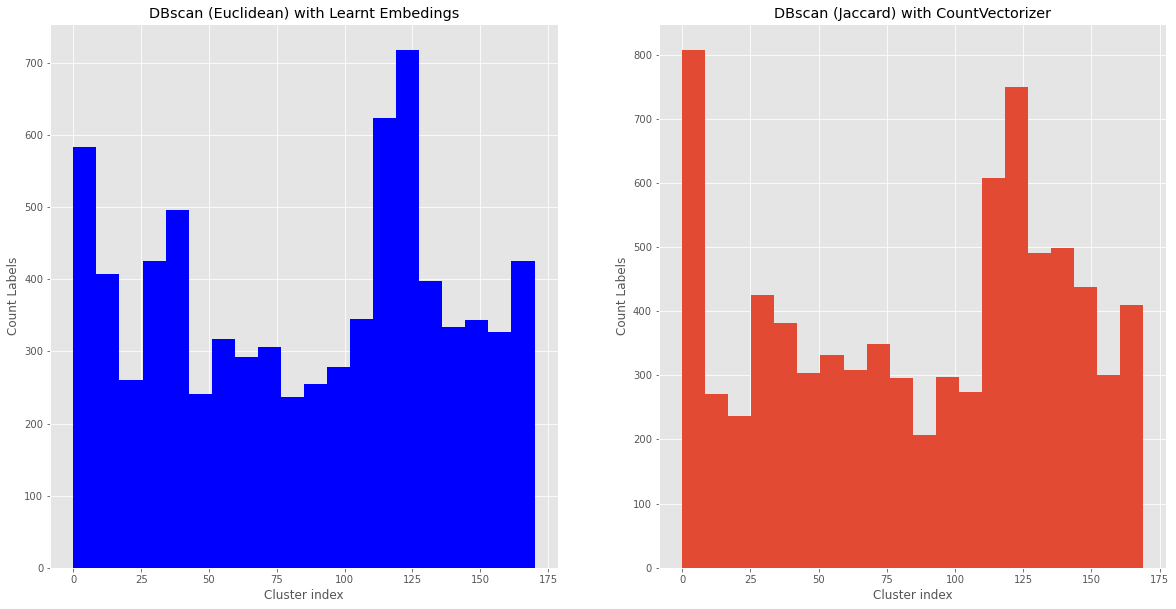

In [50]:
import matplotlib.pyplot as plt

fig =  plt.figure(figsize=(20, 10))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Remove points not clustered inx
compare[
    compare['cluster_with_embedings']!=-1].cluster_with_embedings.plot(
        kind='hist', ax = ax0, bins=20, color='blue')
ax0.set_title ('DBscan (Euclidean) with Learnt Embedings')
ax0.set_ylabel('Count Labels')
ax0.set_xlabel('Cluster index')

compare[
    compare['cluster_with_count_vectorizer']!=-1].cluster_with_count_vectorizer.plot(
        kind='hist', ax = ax1,  bins=20)
ax1.set_title('DBscan (Jaccard) with CountVectorizer')
ax1.set_ylabel('Count Labels')
ax1.set_xlabel('Cluster index')

embedings. Total count in cluster 26. 
embedings. Mean 10.038461538461538. Std 12.494737353720627 
embedings  {'ULT.3473 UN 25KG 5H4', 'ULD.B4406 UN 25KG 5H4', 'ULT.B3S R03 UN 25KG 5H4 V', 'ULD.B4300G4 UN 25KG 5H4', 'ULF.N2320 003 AT UN 25KG 5H4 1', 'ULT.B3WG5 UN 25KG 5H4', 'ULD.B1520 FC R01 UN 25KG 5H4', 'ULT.B3EG7 UN 25KG 5H4', 'ULT.8340 UN 25KG 5H4', 'ULF.N2640 Z2 AT UN 25KG 5H4', 'ULT.A3K UN 25KG 5H4', 'ULT.A3WG7 UN 25KG 5H4', 'ULT.A3EG7 UN 25KG 5H4', 'ULT.B3ZG6 UN 25KG 5H4', 'ULT.A3WG5 UN 25KG 5H4', 'ULD.B4520 UN 25KG 5H4', 'ULT.B3ZG7 SC UN 25KG 5H4 V', 'ULT.A3WG6 UN 25KG 5H4 V', 'ULT.8342 UN 25KG 5H4 V'}. 
************
countVect Total count in cluster 45. 
countVect. Mean 10.8. Std 12.467412066518202 
countVect  {'GLYSANTIN G48 BG PGS 210L 1A1', 'HYDRAULAN 406 ESI 212KG 1A1', 'POLYTHF 2000 3,79KG 1A1', 'TRIBUTYLAMINE 155KG 1A1', 'DIMETHYLPROPYLAMINE 135KG 1A1', 'PLURACOL* 1062 POLYOL 3.629KG 1A1 CI', 'PLURACOL* 2010 POLYOL 4KG 1A1 CI', 'PLURACOL* 2086 POLYOL 3.628KG 1A1 CI', 'EMG

Text(0.5, 0, 'TransportationDays')

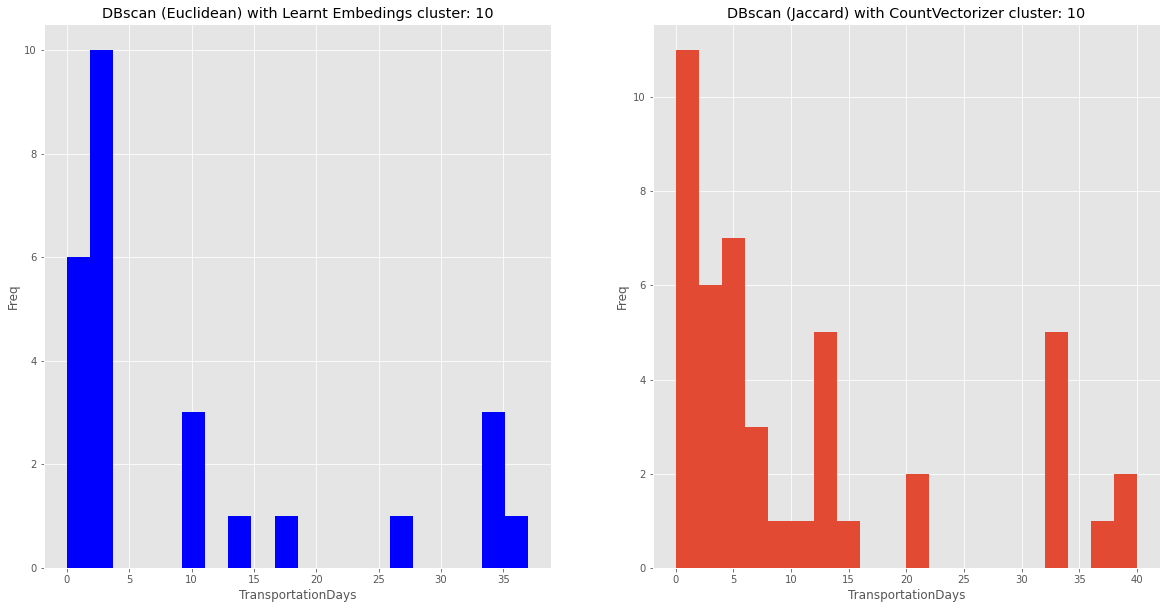

In [89]:
from random import randint

idx_cluster = randint(0, 155)

cluster_component = compare[compare['cluster_with_embedings']==idx_cluster]

count_elements = len(cluster_component)
set_material_in_cluster = set(cluster_component.MaterialDescription)
mean_days = cluster_component.TransportationDays.mean()
std_days = cluster_component.TransportationDays.std()


print(f'embedings. Total count in cluster {count_elements}. ')
print(f'embedings. Mean {mean_days}. Std {std_days} ')
print(f'embedings  {set_material_in_cluster}. ')

cluster_component_vectorizer = compare[compare['cluster_with_count_vectorizer']==idx_cluster]

count_elements = len(cluster_component_vectorizer)
set_material_in_cluster = set(cluster_component_vectorizer.MaterialDescription)
mean_days = cluster_component_vectorizer.TransportationDays.mean()
std_days = cluster_component_vectorizer.TransportationDays.std()
print('************')
print(f'countVect Total count in cluster {count_elements}. ')
print(f'countVect. Mean {mean_days}. Std {std_days} ')
print(f'countVect  {set_material_in_cluster}. ')

############### plot
fig =  plt.figure(figsize=(20, 10))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
cluster_component.TransportationDays.plot(
        kind='hist', ax = ax0, bins=20, color='blue')
ax0.set_title (f'DBscan (Euclidean) with Learnt Embedings cluster: {idx_cluster}')
ax0.set_ylabel('Freq')
ax0.set_xlabel('TransportationDays')

cluster_component_vectorizer.TransportationDays.plot(
        kind='hist', ax = ax1,  bins=20)
ax1.set_title(f'DBscan (Jaccard) with CountVectorizer cluster: {idx_cluster}')
ax1.set_ylabel('Freq')
ax1.set_xlabel('TransportationDays')

+ No obvious problems were detected with either approach.
+ With CountVectorizer the process is simple, yet appropriate similarity measures as Jaccard index, increases computational time.
+ By looking at the distributions of TransportationDays within clustered labels, the Embeding vector tend to have peak points, which tell us that not only semantic meaning of the labels is playing a role into the vectorial representation, but also the TransportationDays that had yield on the past.

# Final test on untunned Logistic regression
+ Use 5 fold cross validation

In [127]:
import warnings
warnings.filterwarnings('ignore')


vectorizer = CountVectorizer(tokenizer= word_tokenize, 
                            token_pattern= None, 
                            max_features= 300)

x_bag_sparce = vectorizer.fit_transform(data_set_train_pd['MaterialDescription'])

# Test on CountVectorizer output
scores = cross_val_score(
    LinearRegression(), 
    X=x_bag_sparce,
    y=data_set_train_pd['TransportationDays'], cv=5, scoring='neg_mean_absolute_error')
print("%0.2f MAE with a standard deviation of %0.2f" % (
                                    -1*scores.mean(), scores.std()))
-1*scores

5.62 MAE with a standard deviation of 0.15


array([5.66168025, 5.56656654, 5.68668011, 5.82269731, 5.37928274])

In [157]:
# With Embedings cluster
x_projection = np.array(vectorial_representation)
scores = cross_val_score(
    LinearRegression(), 
    X=x_projection,
    y=data_set_train_pd['TransportationDays'], cv=5, scoring='neg_mean_absolute_error')
print("%0.2f MAE with a standard deviation of %0.2f" % (
                                    -1*scores.mean(), scores.std()))
-1*scores

6.48 MAE with a standard deviation of 0.10


array([6.35052069, 6.65327886, 6.51816027, 6.44467065, 6.42020011])

+ Use DBSCAN clusters

In [159]:
from sklearn.preprocessing import OneHotEncoder

x_temp = compare[['cluster_with_count_vectorizer']]

#np.array(x_temp)
enco = OneHotEncoder()

x_temp = enco.fit_transform(x_temp)

scores = cross_val_score(
    LinearRegression(), 
    X=x_temp,
    y=data_set_train_pd['TransportationDays'], cv=5, scoring='neg_mean_absolute_error')
print("%0.2f MAE with a standard deviation of %0.2f" % (
                                    -1*scores.mean(), scores.std()))
-1*scores

5.82 MAE with a standard deviation of 0.20


array([5.84410463, 5.96621987, 5.70808845, 6.06126061, 5.50103342])

In [158]:
x_temp = compare[['cluster_with_embedings']]

#np.array(x_temp)
enco = OneHotEncoder()

x_temp = enco.fit_transform(x_temp)

scores = cross_val_score(
    LinearRegression(), 
    X=x_temp,
    y=data_set_train_pd['TransportationDays'], cv=5, scoring='neg_mean_absolute_error')
print("%0.2f MAE with a standard deviation of %0.2f" % (
                                    -1*scores.mean(), scores.std()))
-1*scores

5.77 MAE with a standard deviation of 0.19


array([5.79644149, 5.91089138, 5.68244973, 6.01274799, 5.46309555])